<a target="_blank" href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/rapids-pip-colab-template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Install RAPIDS into Colab"/>
</a>

# RAPIDS cuDF is now already on your Colab instance!
RAPIDS cuDF is preinstalled on Google Colab and instantly accelerates Pandas with zero code changes. [You can quickly get started with our tutorial notebook](https://nvda.ws/rapids-cudf). This notebook template is for users who want to utilize the full suite of the RAPIDS libraries for their workflows on Colab.  

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

You can check the output of `!nvidia-smi` to check which GPU you have.  Please uncomment the cell below if you'd like to do that.  Currently, RAPIDS runs on all available Colab GPU instances.

In [137]:
# !nvidia-smi

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Pip Installs the RAPIDS' libraries, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuxFilter
  1. cuCIM
  1. xgboost

# Controlling Which RAPIDS Version is Installed
This line in the cell below, `!python rapidsai-csp-utils/colab/pip-install.py`, kicks off the RAPIDS installation script.  You can control the RAPIDS version installed by adding either `latest`, `nightlies` or the default/blank option.  Example:

`!python rapidsai-csp-utils/colab/pip-install.py <option>`

You can now tell the script to install:
1. **RAPIDS + Colab Default Version**, by leaving the install script option blank (or giving an invalid option), adds the rest of the RAPIDS libraries to the RAPIDS cuDF library preinstalled on Colab.  **This is the default and recommended version.**  Example: `!python rapidsai-csp-utils/colab/pip-install.py`
1. **Latest known working RAPIDS stable version**, by using the option `latest` upgrades all RAPIDS labraries to the latest working RAPIDS stable version.  Usually early access for future RAPIDS+Colab functionality - some functionality may not work, but can be same as the default version. Example: `!python rapidsai-csp-utils/colab/pip-install.py latest`
1. **the current nightlies version**, by using the option, `nightlies`, installs current RAPIDS nightlies version.  For RAPIDS Developer use - **not recommended/untested**.  Example: `!python rapidsai-csp-utils/colab/pip-install.py nightlies`


**This will complete in about 5-6 minutes**

In [138]:
# # This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py


# RAPIDS is now installed on Colab.  
You can copy your code into the cells below or use the below to validate your RAPIDS installation and version.  
# Enjoy!

In [139]:
import cudf
cudf.__version__

'25.02.01'

In [140]:
import cuml
cuml.__version__

'25.02.01'

In [141]:
# import cugraph
# cugraph.__version__

In [142]:
# import cuspatial
# cuspatial.__version__

In [143]:
# import cuxfilter
# cuxfilter.__version__

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [144]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, silhouette_score
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

from cuml.manifold import TSNE as cuTSNE
import cupy as cp
from cuml.manifold import TSNE as cuTSNE
from cuml.cluster import DBSCAN as cuDBSCAN


import warnings
warnings.filterwarnings('ignore')

# print("Is CUDA available?", torch.cuda.is_available())
# print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

In [145]:
from re import VERBOSE
from os import X_OK
class Ensemble:
    def __init__(self):
        self.__df = None     # data on CPU
        self.__tensor = None # data on GPU
        self.X_cudf = None   # data on GPU for Rapidsai dataframe

        self.__labels = None
        self.__centroids = None
        self.__PCA_components = 2

        self.X_tsne = None
        self.X_pca = None

    def __batched_silhouette_score(self, data, labels, batch_size=5000):
        n_samples = data.shape[0]
        n_batches = (n_samples + batch_size - 1) // batch_size
        scores = []

        for i in range(n_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, n_samples)
            data_batch = data[start:end]
            labels_batch = labels[start:end]

            # Only compute if at least 2 unique labels in batch
            if len(np.unique(labels_batch)) > 1:
                try:
                    score = silhouette_score(data_batch, labels_batch)
                    scores.append(score)
                except:
                    continue

        if scores:
            return np.mean(scores)
        else:
            return None

    def __rapidify(self, X):
        # Convert to cuDF for RAPIDS
        X_cudf = cudf.DataFrame.from_records(X)
        self.X_cudf = X_cudf
        return X_cudf

    def __tensorfy_data(self, X):
        # Convert to PyTorch tensor and move to GPU
        tensor = torch.tensor(X, dtype=torch.float32).cuda()
        self.__tensor = tensor
        return tensor

    def __scale_data(self):
        scaler = StandardScaler()
        self.__df = scaler.fit_transform(self.__df)
        return self

    def __drop_features(self, features):
        self.__df = self.__df.drop(columns=features, axis=1)
        return self

    def get_data(self, count=5):
        if count == "*":
            return self.__df

        return self.__df.head(count)

    def get_labels(self):
        return self.__labels

    def get_centroids(self):
        return self.__centroids

    def get_components_count(self):
        return self.____PCA_components

    def load_data(self, filepath):
        df = pd.read_csv(datasource)
        self.__df = df

    def append_lables(self, title="clusters"):
        # bring the labels back to CPU
        labels = self.__labels.cpu()
        self.__df[title] = labels.numpy()

    def export_to_excel(self, filepath):
        # Export the new data to excel
        self.__df.to_csv(index=False)

    def preprocess_data(self):
        preprocessed_data = self.__drop_features(["time"]).__scale_data().get_data(count="*")
        self.__rapidify(preprocessed_data)
        self.__tensorfy_data(preprocessed_data)

        return preprocessed_data

    def initial_PCA(self, threshold=0.95):
        # Fit PCA without reducing dimensionality yet
        pca = PCA()

        X = self.get_data(count="*")
        print("Time is dropped and the rest of the data is scaled: \n", X)
        pca.fit(X)

        # Cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

        # add the number of components to the global scope
        self.____PCA_components = np.argmax(cumulative_variance >= threshold) + 1

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
        plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
        plt.title('Cumulative Explained Variance by PCA Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def visualize_PCA(self, title=""):
        if self.X_pca is None:
            pca = PCA(n_components=self.____PCA_components)
            X_pca = pca.fit_transform(self.__df)
            self.X_pca = X_pca
        else:
            X_pca = self.X_pca

        plt.figure(figsize=(8,6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, edgecolors='k')
        plt.xlabel('Primary Voltage (A)')
        plt.ylabel('Secondary Voltage (A)')
        plt.title(title)
        plt.grid(True)
        plt.show()

    def visualize_TSNE(self, title=""):
        X_cudf = self.__rapidify(self.__df)
        tsne = cuTSNE(
            n_components=2,
            perplexity=30,
            n_iter=1000,
            random_state=42,
            metric="euclidean",
            verbose=True,
        )
        X_tsne = tsne.fit_transform(X_cudf)
        self.X_tsne = X_tsne

        # Plot
        X_tsne_np = X_tsne.to_numpy()

        plt.figure(figsize=(8,6))
        plt.scatter(X_tsne_np[:, 0], X_tsne_np[:, 1], s=10, alpha=0.7)
        plt.title(title)
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.grid(True)
        plt.show()

    def dbscan(self, eps=3, min_samples=10):
        db = cuDBSCAN(eps=eps, min_samples=min_samples)
        self.__labels = db.fit_predict(self.X_tsne)

    def kmeans_torch(self, num_clusters=5, num_iters=100):
        X = self.__tensorfy_data(self.X_pca)

        N, D = X.shape
        # Initialize centroids randomly from the dataset
        centroids = X[torch.randperm(N)[:num_clusters]]

        for _ in range(num_iters):
            # Compute distances and assign clusters
            distances = torch.cdist(X, centroids)
            labels = torch.argmin(distances, dim=1)

            # Update centroids
            for k in range(num_clusters):
                mask = labels == k
                if mask.sum() == 0:
                    continue  # Avoid empty cluster
                centroids[k] = X[mask].mean(dim=0)

        self.__labels = labels
        self.__centroids = centroids

    def evaluate_kmeans(self, batch_size=5000):
        data_cpu = self.__tensor.detach().cpu().numpy()  # shape: (N, D)
        labels_cpu = self.__labels.detach().cpu().numpy()  # shape: (N,)
        sil_score = self.__batched_silhouette_score(data_cpu, labels_cpu, batch_size=5000)
        print(f"Silhouette Score: {sil_score:.3f}")

        self.visualize_PCA("'K-Means Clusters (PCA projection)'")

    def evaluate_dbscan(self, eps=3):
        data_cpu = self.__tensor.detach().cpu().numpy()  # shape: (N, D)
        labels_cpu = self.__labels.detach().cpu().numpy()  # shape: (N,)
        sil_score = self.__batched_silhouette_score(data_cpu, labels_cpu, batch_size=5000)
        print(f"Silhouette Score: {sil_score:.3f}")

        n_clusters = len(set(self.__labels)) - (1 if -1 in self.__labels else 0)
        n_noise = list(self.__labels).count(-1)
        title = f"DBSCAN Clustering (eps={eps})\nClusters: {n_clusters}, Noise: {n_noise}"

        labels_np = self.__labels.to_numpy()
        X_tsne_np = self.X_tsne.to_numpy()

        plt.figure(figsize=(8,6))
        plt.scatter(X_tsne_np[:, 0], X_tsne_np[:, 1], c=labels_np, cmap='tab10', s=10)
        plt.title("cuML t-SNE + DBSCAN Clustering")
        plt.xlabel("t-SNE Dim 1")
        plt.ylabel("t-SNE Dim 2")
        plt.grid(True)
        plt.colorbar(label="Cluster Label")
        plt.tight_layout()
        plt.show()


In [146]:
# from google.colab import drive
# drive.mount('/content/drive')

In [147]:
datasource = "./drive/MyDrive/ML/Final project/data/fault_data.csv" # dynamically change the data source
ensemble = Ensemble()
ensemble.load_data(datasource)
data = ensemble.get_data()
data

,time,current_a_p,current_b_p,current_c_p,current_a_s,current_b_s,current_c_s,voltage_a_p,voltage_b_p,voltage_c_p,voltage_a_s,voltage_b_s,voltage_c_s
0,0.00000,-6.602189,0.990079,5.612111,-6.535661,1.014269,5.521391,337.545334,-60970.55816,60633.01282,-289.112071,-12016.96551,12306.07758
1,0.00001,-6.233351,0.967566,5.625489,-6.528825,0.992188,5.534840,-0.348616,-61187.28941,60413.54476,-253.313296,-12042.60194,12281.83427
2,0.00002,-6.371119,0.944881,5.638660,-6.522568,0.970013,5.548161,-0.818920,-61354.55300,60242.64442,-227.840328,-12071.89074,12253.75854
3,0.00003,-6.339148,0.921937,5.651526,-6.517002,0.947740,5.561338,-0.333370,-61538.02524,60054.33583,-220.104251,-12107.75389,12218.86837
4,0.00004,-6.265568,0.898868,5.664220,-6.511395,0.925512,5.574516,-0.693892,-61732.62988,59853.69575,-228.138717,-12150.02487,12177.33032


In [148]:
preprocessed_data = ensemble.preprocess_data()
preprocessed_data

array([[-0.17240269,  0.02306107,  0.1639487 , ..., -0.04480299,
        -2.35346507,  2.13037825],
       [-0.16407621,  0.02255848,  0.16427882, ..., -0.03809743,
        -2.35847276,  2.12617182],
       [-0.16718631,  0.02205204,  0.16460382, ..., -0.03332603,
        -2.36419388,  2.12130043],
       ...,
       [-0.17277958,  0.02404803,  0.16326982, ..., -0.06133876,
        -2.34449966,  2.13773181],
       [-0.17259252,  0.02355376,  0.16361166, ..., -0.05307597,
        -2.3489938 ,  2.1340699 ],
       [-0.17240399,  0.02305926,  0.16395214, ..., -0.04481233,
        -2.35346165,  2.13038386]])

Time is dropped and the rest of the data is scaled: 
 [[-0.17240269  0.02306107  0.1639487  ... -0.04480299 -2.35346507
   2.13037825]
 [-0.16407621  0.02255848  0.16427882 ... -0.03809743 -2.35847276
   2.12617182]
 [-0.16718631  0.02205204  0.16460382 ... -0.03332603 -2.36419388
   2.12130043]
 ...
 [-0.17277958  0.02404803  0.16326982 ... -0.06133876 -2.34449966
   2.13773181]
 [-0.17259252  0.02355376  0.16361166 ... -0.05307597 -2.3489938
   2.1340699 ]
 [-0.17240399  0.02305926  0.16395214 ... -0.04481233 -2.35346165
   2.13038386]]


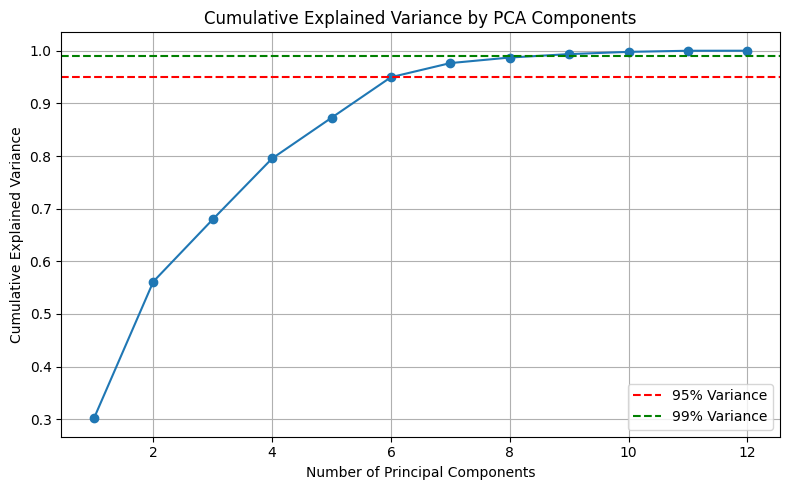

Number of components to Use:  7
[2025-04-26 01:06:00.794] [CUML] [debug] Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
[2025-04-26 01:06:00.794] [CUML] [debug] cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
[2025-04-26 01:06:00.794] [CUML] [debug] New n_neighbors = 30, learning_rate = 70002.33333333333, exaggeration = 24.0
[2025-04-26 01:06:00.794] [CUML] [debug] Data size = (210007, 12) with dim = 2 perplexity = 30.000000
[2025-04-26 01:06:00.794] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[2025-04-26 01:06:00.794] [CUML] [debug] Getting distances.
[2025-04-26 01:06:04.683] [CUML] [debug] Now normalizing distances so exp(D) doesn't explode.
[2025-04-26 01:06:04.689] [CUML] [debug] Searching for optimal perplexity via bisection search.
[2025-04-26 0

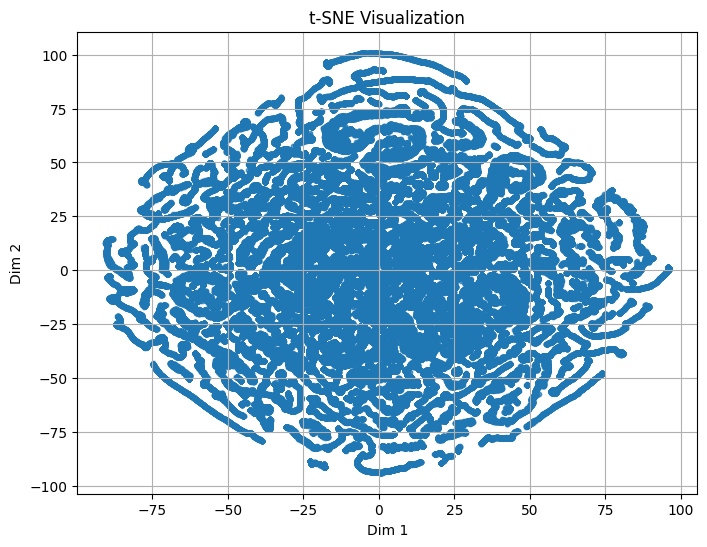

In [149]:
# preprocess data
ensemble.initial_PCA()
print("Number of components to Use: ", ensemble.get_components_count())

# ensemble.visualize_PCA('PCA Scatter Plot of the Dataset')
ensemble.visualize_TSNE("t-SNE Visualization")

In [151]:
# Train the model on GPU
# num_clusters = 6
# ensemble.kmeans_torch(num_clusters=num_clusters, num_iters=50)
# print("Cluster centroids:", ensemble.get_centroids().cpu().numpy())

ensemble.dbscan(3)

print("Cluster labels (first 10):", ensemble.get_labels()[:10].to_numpy())

[2025-04-26 01:11:42.044] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 12055 -> 10225. Using the larger integer type might result in better performance
Cluster labels (first 10): [0 0 0 0 0 0 0 0 0 0]
